#챗봇 만들기와 웹사이트에 적용시켜보기!


이번 프로젝트는 챗봇만들기이다.

프로젝트를 진행하면서 들었던 의문은 만들어야하는게 챗봇인데 결과를 출력해주는 함수를 만들고

그때그때 대답을 입력하고 코드상으로 보여주는건 챗봇이 아니라고 생각했다.

본래 챗봇은 채팅을 하는것처럼 이뤄져야한다.

따라서 이번 프로젝트에서는 챗봇 사이트를 만들어서 그 안에서 채팅을 이뤄질 수 있게 하는 것이 최종 목표이다.

시간이 남으면 배포까지 끝내서 다른 교육생분들과 함께 즐기고 싶다.

(이때 그만두었어야했다...... 채팅웹은 만들지 말았어야했다..... 그냥 내 할일이나 제대로할껄 ㅠㅠㅠㅠ)



</br>


☝목차


📚라이브러리 임포트 및 구글 드라이브연동

📚데이터 전처리 및 토큰화

📚모델 제작

📚encoder&decoder 처리

📚dataset만들기 & transformer모델정의

📚모델생성과 학습

📚학습정보 시각화

📚챗봇 결과확인

📚중간 마무리

---

</br>

☝개인목표(챗봇만들기)

📚input으로 입력시 잘받아지는지 확인

📚웹사이트 구현 라이브러리 설치

📚파이참에서 구현

📚회고

---

##1.라이브러리 임포트 및 구글 드라이브 연동
###1-1.구글 드라이브 및 라이브러리 임포트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

###1-2.데이터 확인

밑에 링크로 들어가서 데이터를 다운 받아준다.

링크 : https://github.com/songys/Chatbot_data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/pic/ex/ChatbotData .csv')
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


---------------

##2.데이터 전처리 및 토큰화
###2-1.데이터 전처리

사용할 샘플의 갯수를 지정해준다.

In [ ]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [ ]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
def load_conversations(questions, answers):
  inputs, outputs = [], []

  for question, answer in zip(questions, answers):
      inputs.append(preprocess_sentence(question))
      outputs.append(preprocess_sentence(answer))
        
  return inputs, outputs

In [ ]:
questions, answers = load_conversations(df['Q'], df['A'])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

print('전처리 후의 26번째 질문 샘플: {}'.format(questions[25]))
print('전처리 후의 26번째 답변 샘플: {}'.format(answers[25]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823
전처리 후의 26번째 질문 샘플: 가족 여행 어디로 가지 ?
전처리 후의 26번째 답변 샘플: 온 가족이 모두 마음에 드는 곳으로 가보세요 .


###2-2.Token화

SubwordTextEncoder를 활용하여 토큰화 진행

tokenize_and_filter 함수
- 정수 인코딩
- 최대 길이를 초과하는 샘플 제거
- 최대 길이보다 짧을 경우, 패딩 수행

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

VOCAB_SIZE = tokenizer.vocab_size + 2

print('정수 인코딩 후의 26번째 질문 샘플: {}'.format(tokenizer.encode(questions[25])))
print('정수 인코딩 후의 26번째 답변 샘플: {}'.format(tokenizer.encode(answers[25])))

2022-06-15 03:33:36.726 SubwordTextEncoder build: trying min_token_count 6695
2022-06-15 03:33:37.977 SubwordTextEncoder build: trying min_token_count 3347
2022-06-15 03:33:39.244 SubwordTextEncoder build: trying min_token_count 1673
2022-06-15 03:33:40.469 SubwordTextEncoder build: trying min_token_count 836
2022-06-15 03:33:41.643 SubwordTextEncoder build: trying min_token_count 418
2022-06-15 03:33:42.790 SubwordTextEncoder build: trying min_token_count 209
2022-06-15 03:33:43.887 SubwordTextEncoder build: trying min_token_count 104
2022-06-15 03:33:44.985 SubwordTextEncoder build: trying min_token_count 52
2022-06-15 03:33:45.993 SubwordTextEncoder build: trying min_token_count 26
2022-06-15 03:33:46.978 SubwordTextEncoder build: trying min_token_count 13
2022-06-15 03:33:48.006 SubwordTextEncoder build: trying min_token_count 6
2022-06-15 03:33:48.988 SubwordTextEncoder build: trying min_token_count 3
2022-06-15 03:33:50.049 SubwordTextEncoder build: trying min_token_count 4


정수 인코딩 후의 26번째 질문 샘플: [5753, 429, 4132, 1055, 2]
정수 인코딩 후의 26번째 답변 샘플: [1087, 3173, 591, 264, 878, 621, 287, 1]


In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


---

##3.모델 제작
###3-1.PositionalEncoding

In [ ]:
# PositionalEncoding
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) /
                            tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

###3-2.scaled_dot_product_attention

In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

###3-3.MultiHeadAttention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

###3-4.create_padding_mask

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

###3-5.create_look_ahead_mask

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

---

##4.encoder&decoder 처리
###4-1.encoder

transfomer에서는 encoder_layer와 encoder, decoder_layer와 decoder

이렇게 두가지를 사용한다.

즉, 구현할 부분이 상당히 많다.

In [ ]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
          })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

###4-2.decoder 처리

In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

---

##5.dataset만들기 & transformer모델정의
###5-1.dataset제작

answer[:,:-1]를 decoder 입력값, answer[:,1:]를 decoder 레이블로 사용

tensorflow의 data.Dataset이라는 API를 활용하여 파이프라인을 구축해준다.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

2022-06-15 03:33:52.491781: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


###5-2.transformer모델정의

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크하기위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

      # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
      )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    4200448     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

---

##6.모델생성과 학습
###6-1.손실함수정의

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

###6-2.커스텀 학습률

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

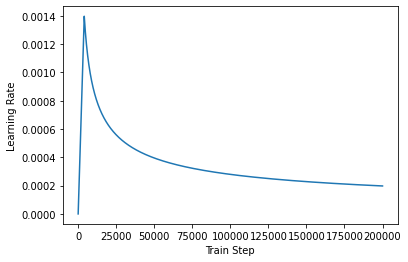

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

###6-3.모델 컴파일 및 학습

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 28s 87ms/step - loss: 1.4366 - accuracy: 0.0220
Epoch 2/50
185/185 [==============================] - 16s 87ms/step - loss: 1.1754 - accuracy: 0.0481
Epoch 3/50
185/185 [==============================] - 17s 90ms/step - loss: 1.0080 - accuracy: 0.0505
Epoch 4/50
185/185 [==============================] - 16s 86ms/step - loss: 0.9386 - accuracy: 0.0541
Epoch 5/50
185/185 [==============================] - 16s 86ms/step - loss: 0.8911 - accuracy: 0.0564
Epoch 6/50
185/185 [==============================] - 16s 87ms/step - loss: 0.8455 - accuracy: 0.0587
Epoch 7/50
185/185 [==============================] - 16s 89ms/step - loss: 0.7935 - accuracy: 0.0623
Epoch 8/50
185/185 [==============================] - 16s 86ms/step - loss: 0.7347 - accuracy: 0.0669
Epoch 9/50
185/185 [==============================] - 16s 87ms/step - loss: 0.6701 - accuracy: 0.0737
Epoch 10/50
185/185 [==============================] - 16s 86ms/step - loss: 0.601

---

##7.학습정보 시각화

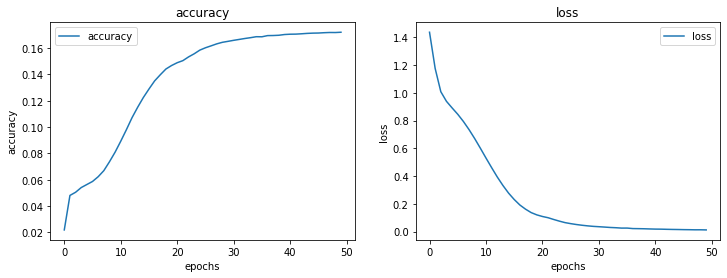

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'])
plt.legend(['accuracy'], loc='best')

plt.subplot(122)
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history.history['loss'])
plt.legend(['loss'], loc='best')
plt.show()

---

##8.챗봇 결과확인

In [ ]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞 뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [ ]:
sentence_generation('추워')

입력 : 추워
출력 : 따듯한 차 한잔 어때요 ?


'따듯한 차 한잔 어때요 ?'

In [ ]:
sentence_generation('끝')

입력 : 끝
출력 : 잘 견뎌내고 있는 것 같네요 .


'잘 견뎌내고 있는 것 같네요 .'

In [ ]:
sentence_generation('여행갈까?')

입력 : 여행갈까?
출력 : 편하게 쉴 수 있는 곳이 좋을 거예요 .


'편하게 쉴 수 있는 곳이 좋을 거예요 .'

In [ ]:
sentence_generation('눈물')

입력 : 눈물
출력 : 지금은 우세요 .


'지금은 우세요 .'

In [ ]:
sentence_generation('식욕폭발해서 폭풍 먹방 찍었어')

입력 : 식욕폭발해서 폭풍 먹방 찍었어
출력 : 맛있게 먹으면 영칼로리 !


'맛있게 먹으면 영칼로리 !'

In [ ]:
sentence_generation('그냥 무작정 그녀 집에 갑니다')

입력 : 그냥 무작정 그녀 집에 갑니다
출력 : 행동파시군요 .


'행동파시군요 .'

In [ ]:
sentence_generation('라면먹고 갈래?')

입력 : 라면먹고 갈래?
출력 : 엄청난 용기가 필요하겠네요 .


'엄청난 용기가 필요하겠네요 .'

----

##중간 마무리

한국어 전처리는 영어와는 살짝다르다고 생각해 약간 다르게 작성하였다.


```
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # 한글, 영어, 숫자, 4개의 구두점(? ! , .)을 제외한 모든 문자를 공백인 ' '로 대체
  sentence = re.sub(r"[^ㄱ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
```

그리고 나머지는 **하이퍼파라미터 수정과 epochs수를 늘렸다**.

**그 결과 loss값은 안정적으로 줄고 accuracy는 꾸준히 상승하는 모습을 보여**주었다.

이번 프로젝트에서 **의문점은 과연 accuracy가 필요한가?** 이다.

분류모델이면 정확도는 많아 봤자 **20퍼안되는 수치**이다.

하지만 **loss값은 지나치게 낮고 결과를 확인해봐도 상당히 학습이 잘된것으로 보여**진다.

기준을 무엇으로 잡아야할지 애매했다.

**마지막으로는 생소한 파라미터가 등장**한것이다.

정확한 이해를 위해서 **추후에 공부를 해야한다고 생각**하였다.

-----

##개인목표(챗봇 사이트 만들기)

우선 위에서 만든 출력함수는


```
print('입력 : {}'.format(sentence))
print('출력 : {}'.format(predicted_sentence))
```
이런식으로 되어있어 코드 결과에 입,출력이 모두 나오게 된다.

그렇게 나오지 않게 함수를 약간 수정해주자



In [ ]:
def sentence_generation1(sentence):
    # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print(predicted_sentence)

##개인목표1.input으로 입력시 잘받아지는지 확인

웹사이트를 만들게 되면 데이터를 입력받아 그 데이터에 맞는 정답을
출력해주어야 한다.

따라서 input이라는 파이썬 기능을 사용하여 데이터를 입력받고 그에 적합한 결과를 보여주는지 확인해보자

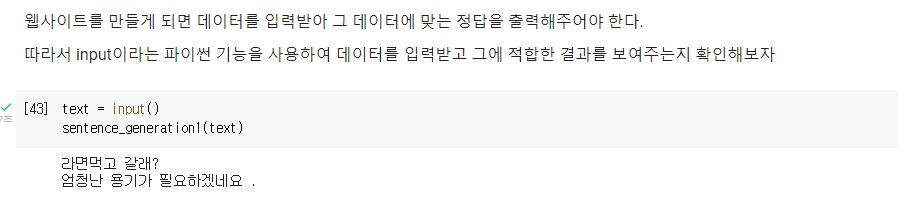

중간에 코랩 메모리가 터져서 사진으로 대체하였습니다.....

---

##개인목표2.웹사이트 구현 라이브러리 설치

웹사이트구현으로는 streamlit이라는 라이브러리를 사용

웹관련 프레임워크를 사용하는게 적합하겠지만 빠른 구현과 배우기 쉬운 라이브러리인 streamlit을 사용하여 개발

관련 링크 : https://mokeya.tistory.com/147

공식 링크 : https://streamlit.io/

In [ ]:
!pip install streamlit

In [ ]:
import streamlit as st

st.title("hobbak chatbot")
input = st.text_input(label="채팅입력", value="", max_chars=10, help='input message < 10')
st.write(sentence_generation1(input))

---

##개인목표3.파이참에서 구현

코랩은 구글 서버를 사용하고 있고 확장자도 ipynb이기 때문에(streamlit은 py 확장자이어야함)
  
실행이 되어도 서버를 열지 못하는것으로 보인다.

개인 노트북에 깔려있는 파이참으로 실행을 해봄

노트북 연식이 조금되어서 에포크를 10으로 하고 실행함

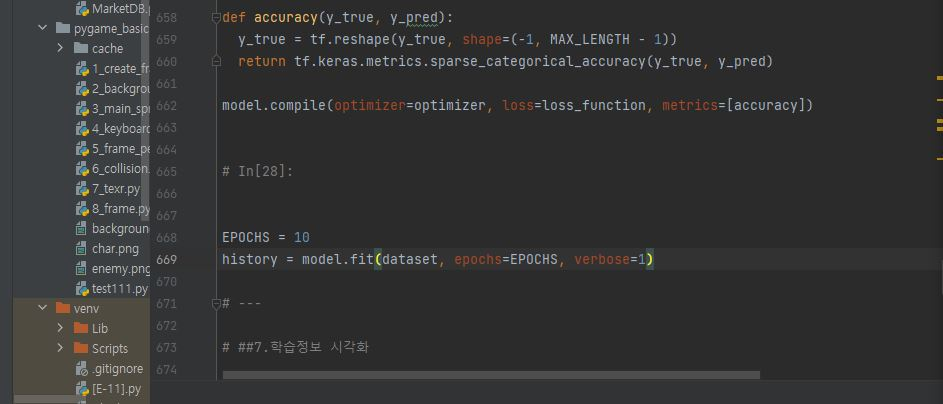

저 상태로 실행을 시키니 저런 메세지가 출력됨

커맨드창에 저 상태로 입력하는 뜻같아서 Terminal 버튼을 눌러 입력해봄

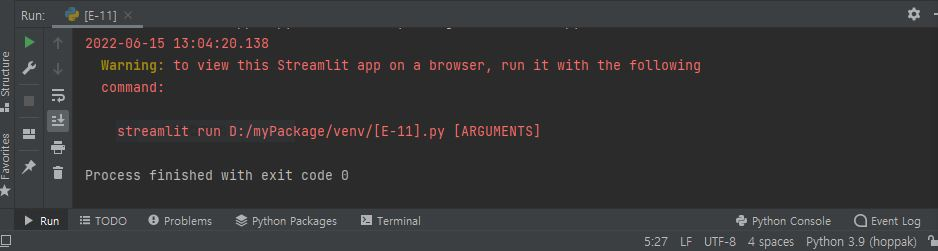

You can now view your Streamlit app in your browser.

라는 메세지가 출려되고 밑에 주소가 나온다.

그 주소로 들어가보겠다.

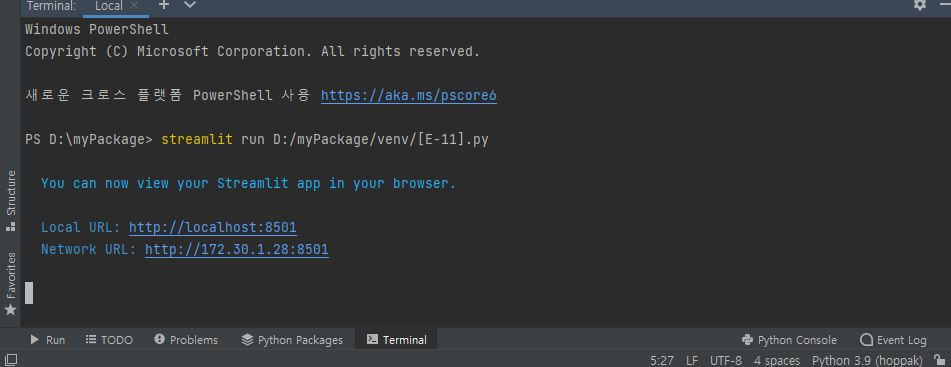

후욱후욱후욱후욱 제대로 실행이 된거같다.

한번 내용을 입력해보겠다.

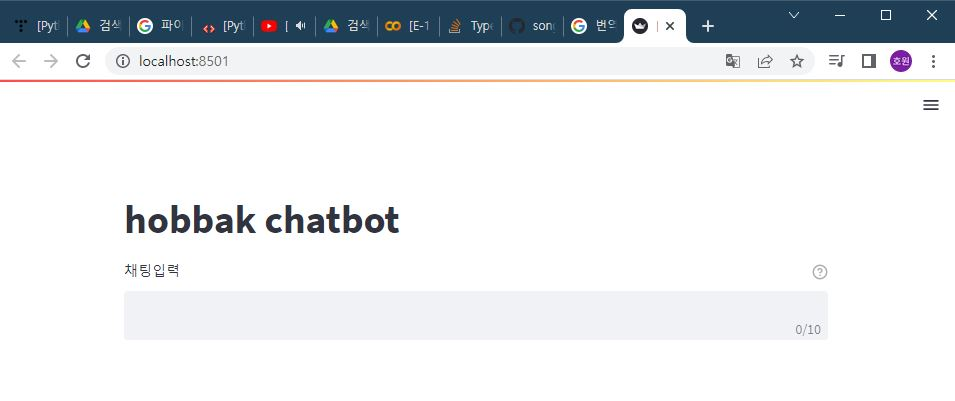

끼애앵애애애애애애애애ㅐ애애애애ㅐ애애애ㅐㅐㅐㅐㅐㅐㅐㅐㅐㅐㅐㅐㅐㅐㅐㅐㅐㅐㅐ애애애애애액

잘되는거 확인이 가능하다.

목표달성!

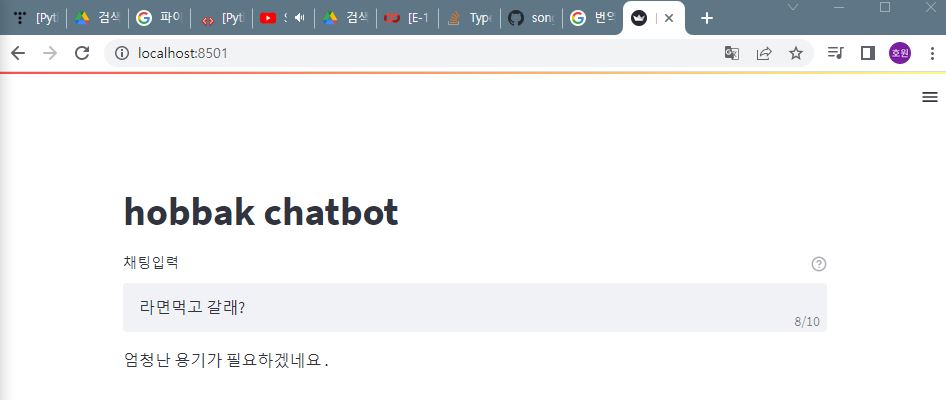

---

##회고

기존의 라이브러리들은 코랩에서도 실행이 되었지만, streamlit은 그러지못했다.

아마 구글서버를 빌려 사용하는 코랩이라서 지원이 안된다고 생각한다.

개인적으로 웹사이트 구현부분에서 **아쉬운점은 코랩처럼 gpu를 빌려 사용하는것이 아니고**

개인자원을 그대로 사용해서 그런지 **학습 속도가 매우매우매우 느렸다**.

그 결과 시간이 오래걸려 **epochs를 10으로 하고 학습시켰고 정확도가 높게 나오지 못하였다**.

그 다음으로는 **배포를 아직 못한점**이다.

**배포까지 끝내서 링크를 업로드 시키고 싶었지만... 시간이 부족한 관계로 완벽히 끝마치지 못하였다**.

하지만 추후에 계속 진행할 예정이므로 빠른 시일안에 배포를 할 수 있을거 같다.

---

참고

https://hello-bryan.tistory.com/387

https://toward-the-future.tistory.com/entry/Python-%ED%8C%8C%EC%9D%B4%EC%B0%B8Pycharm-%EC%84%A4%EC%B9%98-%EB%B0%8F-%EC%95%84%EB%82%98%EC%BD%98%EB%8B%A4anaconda-%EA%B0%80%EC%83%81%ED%99%98%EA%B2%BD-%EC%97%B0%EB%8F%99%ED%95%98%EA%B8%B0

https://mokeya.tistory.com/147
